In [1]:
# Importing requird python packages
# Path to hsmpy package
HSMPY_PATH = r'C:\Users\MR068144\Downloads\Python Scripts'
import sys, os, arcpy, csv, json, math
sys.path.append(HSMPY_PATH)
import hsmpy3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from IPython.display import Image
from IPython.core.display import HTML 
import subprocess 
import webbrowser
import time
import copy
import shutil
from time import gmtime, strftime
from ipywidgets import FloatProgress
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-10-08 08:26:31


In [2]:
# Defining Parameteres
print(strftime("%Y-%m-%d %H:%M:%S"))
Years = range(2012,2017)
MaxOpenProcesses = 15
Project_DIR  = r'\\CHCFPP01\Proj\ILDOT\650511SAFETYPROGRAM\4_WorkData\WO00_OtherStates\NewMexico\3_WorkData\7_NetworkScreening'
ReceivedDir  = Project_DIR + '\\2.Received_Data'
Project_GDB  = Project_DIR + '\\5.NM_NS_GDB.gdb'
PythonDir   = Project_DIR + '\\6.Python_Notebook'

Src_Loc  = ReceivedDir + '\\crash_asof_11jun2018.csv'
Src_Unit = ReceivedDir + '\\vehicle_asof_11jun2018.csv'
Src_Occ  = ReceivedDir + '\\occupant_asof_11jun2018.csv'

Src_Ped_Loc  = ReceivedDir + '\\Ped_2017_KAB\\crashkabped.csv'
Src_Ped_Unit = ReceivedDir + '\\Ped_2017_KAB\\vehiclekabped.csv'
Src_Ped_Occ  = ReceivedDir + '\\Ped_2017_KAB\\occkabped.csv'

HPMS105 = {year:ReceivedDir + '\\v105\\jg_request.gdb\\HPMS{}Data'.format(year) for year in Years}
HPMS10  = {year:ReceivedDir + '\\v10\\jg_request.gdb\\HPMS{}Data'.format(year) for year in Years}

FOU_2017_105 = ReceivedDir + '\\v105\\jg_request.gdb\\HPMS2017Ownership_Urban_FuncSys'
FOU_2017_10  = ReceivedDir + '\\v10\\jg_request.gdb\\HPMS2017Ownership_Urban_FuncSys'

FHWA_HPMS     = {year:ReceivedDir + '\\FHWA_HPMS\\newmexico{}\\NewMexico{}.shp'.format(year,year) for year in Years}
MS2_HPMS_2017 = {year:ReceivedDir + '\\NM_HPMS_N2017_A{}.csv'.format(year) for year in Years}

Routes  = {year:Project_GDB + '\\Routes_{}'.format(year) for year in Years}
AttTabs = {year:Project_GDB + '\\SegAtt_{}'.format(year) for year in Years}
Segs    = {year:Project_GDB + '\\Seg_{}'.format(year) for year in Years}
CrashData = {year:Project_GDB + '\\Crash_{}'.format(year) for year in range(2012,2018)}

UTM13N   = arcpy.SpatialReference(26913)
NAD83_NM = arcpy.SpatialReference(6529)

RouteID = "ROUTE_ID"
BEG_STA = 'BEG_POINT'
END_STA = 'END_POINT'
Fields = ['F_SYSTEM','THROUGH_LANES','FACILITY_TYPE','AADT','MEDIAN_TYPE','SPEED_LIMIT','LANE_WIDTH']

2018-10-08 08:26:31


In [3]:
# Read Crash Data
print(strftime("%Y-%m-%d %H:%M:%S"))
Crash_DF = pd.concat([hsmpy3.common.FCtoDF(CrashData[year],readGeometry=True) for year in range(2012,2018)])
Crash_DF['Year'] = [d.year for d in Crash_DF.Date]
Crash_DF['PedCrashCount'] = [{True:1,False:0}[sum([k,a,b])>0] for k,a,b in zip(Crash_DF.PedK,Crash_DF.PedA,Crash_DF.PedB)]
Crash_DF['Count'] = 1
Crash_DF['KAB'] = Crash_DF.Killed + Crash_DF.ClassA + Crash_DF.ClassB
Crash_DF.index = ['{}_{}'.format(y,u) for u,y in zip(Crash_DF.UCRnum,Crash_DF.Year)]
display(pd.DataFrame(Crash_DF.groupby(['Year'])['Count','Killed','ClassA','ClassB','PedCrashCount','PedK','PedA','PedB'].aggregate(np.sum)))
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-09-10 14:18:54


,Count,Killed,ClassA,ClassB,PedCrashCount,PedK,PedA,PedB
Year,,,,,,,,
2012,4143,362,1592,3456,242,61,58,129
2013,4069,311,1290,3534,281,53,95,141
2014,4398,384,1241,3840,350,74,94,189
2015,4903,298,1325,4511,378,55,126,211
2016,5048,405,1153,4750,353,77,84,204
2017,342,74,83,197,342,74,82,191


2018-09-10 14:20:33


In [4]:
sel_i = Crash_DF.index[Crash_DF.RID_P=='']
Crash_DF.loc[sel_i,'CFType'] = 'Not Close To Any Road'

sel_i = Crash_DF.index[(Crash_DF.RID_P!='') & (pd.isnull(Crash_DF.FType)) & (Crash_DF.Int_ID==0)]
Crash_DF.loc[sel_i,'CFType'] = 'Roadway PG Not Defined'

sel_i = Crash_DF.index[(Crash_DF.RID_P!='') & (~pd.isnull(Crash_DF.FType)) & (Crash_DF.Int_ID==0)]
Crash_DF.loc[sel_i,'CFType'] = Crash_DF.loc[sel_i,'FType']

sel_i = Crash_DF.index[(Crash_DF.RID_P!='') & (Crash_DF.Int_ID>0) & (pd.isnull(Crash_DF.IFType))]
Crash_DF.loc[sel_i,'CFType'] = 'Int PG Not Defined'

sel_i = Crash_DF.index[(Crash_DF.RID_P!='') & (~pd.isnull(Crash_DF.IFType))]
Crash_DF.loc[sel_i,'CFType'] = Crash_DF.loc[sel_i,'IFType']

In [5]:
def CrashAssignmentRes(ft):
    FTypes = ['R4F','U4F','U6F','R2U','U2U','R4U','R4D','U4U','U4D','U6U']
    IFTypes = ['R3ST','R4ST','R4SG','RM3ST','RM4ST','RM4SG','U3ST','U4ST','U3SG','U4SG']
    if ft in FTypes:
            return('Roadway Related')
    elif ft in IFTypes:
            return('Intersection Related')
    elif ft in ['Not Close To Any Road']:
            return('Unknown')
    elif ft in ['Int PG Not Defined']:
            return('Intersection Related')
    else:
            return('Roadway Related')
        
Crash_DF['Assigned1'] = [CrashAssignmentRes(ft) for ft in Crash_DF.CFType]
df = pd.DataFrame(Crash_DF.groupby(['Year','Assigned1'])['UCRnum'].aggregate(np.count_nonzero))
df['Year'] = [i[0] for i in list(df.index)]
df['Percentage'] = [d/float(sum(df[df.Year==y].UCRnum)) for d,y in zip(df.UCRnum,df.Year)]
df = df[['Percentage']]
df.columns = ['Percentage']
df = df.unstack('Year')
df.loc['Total'] = [sum(df[c]) for c in df.columns]
pd.options.display.float_format = '{:0.2%}'.format
df

Percentage                                        
Year                       2012    2013    2014    2015    2016    2017
Assigned1                                                              
Intersection Related     61.96%  64.98%  63.26%  64.86%  63.17%  75.44%
Roadway Related          37.68%  34.82%  36.27%  34.86%  36.65%  24.27%
Unknown                   0.36%   0.20%   0.48%   0.29%   0.18%   0.29%
Total                   100.00% 100.00% 100.00% 100.00% 100.00% 100.00%

In [6]:
def CrashAssignmentRes(ft):
    FTypes = ['R4F','U4F','U6F','R2U','U2U','R4U','R4D','U4U','U4D','U6U']
    IFTypes = ['R3ST','R4ST','R4SG','RM3ST','RM4ST','RM4SG','U3ST','U4ST','U3SG','U4SG']
    if ft in FTypes:
            return('Assigned to Selected Roadways Types')
    elif ft in IFTypes:
            return('Assigned to Selected Intersection Types')
    elif ft in ['Not Close To Any Road']:
            return('Not Assigned to Any Route')
    elif ft in ['Int PG Not Defined']:
        return('Assigned to Other Int Types')
    else:
            return('Assigned to Other Roadways Types')
Crash_DF['Assigned2'] = [CrashAssignmentRes(ft) for ft in Crash_DF.CFType]
df = pd.DataFrame(Crash_DF.groupby(['Year','Assigned2'])['UCRnum'].aggregate(np.count_nonzero))
df['Year'] = [i[0] for i in list(df.index)]
df['Percentage'] = [d/float(sum(df[df.Year==y].UCRnum)) for d,y in zip(df.UCRnum,df.Year)]
df = df[['UCRnum','Percentage']]
df.columns = ['Count','Percentage']
df = df.unstack('Year')
df

Count                               \
Year                                     2012  2013  2014  2015  2016 2017   
Assigned2                                                                    
Assigned to Other Int Types               781   793   860  1028  1065  116   
Assigned to Other Roadways Types          291   288   323   336   389   24   
Assigned to Selected Intersection Types  1786  1851  1922  2152  2124  142   
Assigned to Selected Roadways Types      1270  1129  1272  1373  1461   59   
Not Assigned to Any Route                  15     8    21    14     9    1   

                                        Percentage                       \
Year                                          2012   2013   2014   2015   
Assigned2                                                                 
Assigned to Other Int Types                 18.85% 19.49% 19.55% 20.97%   
Assigned to Other Roadways Types             7.02%  7.08%  7.34%  6.85%   
Assigned to Selected Intersection Types     43.11% 45.49% 43.70% 43.89%   
Assigned to Selected Roadways Types         30.65% 27.75% 28.92% 28.00%   
Not Assigned to Any Route                    0.36%  0.20%  0.48%  0.29%   

                                                       
Year                                      2016   2017  
Assigned2                                              
Assigned to Other Int Types             21.10% 33.92%  
Assigned to Other Roadways Types         7.71%  7.02%  
Assigned to Selected Intersection Types 42.08% 41.52%  
Assigned to Selected Roadways Types     28.94% 17.25%  
Not Assigned to Any Route                0.18%  0.29%

In [7]:
# Read Roadway Attribute Data
print(strftime("%Y-%m-%d %H:%M:%S"))
Segs_DF = pd.DataFrame()
for year in Years:
    df = hsmpy3.common.FCtoDF(Segs[year],False)
    df['P3'] = [r.ROUTE_ID.split('-')[2] for i,r in df.iterrows()]
    #df = df[(df.P3 =='P')]
    df['Mileage'] = df.Shape_Length/5280
    df['Year'] = year
    #df['AADT'] = [ConvToFloat(aadt) for aadt in list(df.AADT)]
    df['VMT'] = [aadt*365*leng for aadt,leng in zip(list(df.AADT),list(df.Mileage))]
    cf = Crash_DF[(Crash_DF.Year==year) & (Crash_DF.Assigned1=='Roadway Related')].groupby(['SegID'])['Killed','ClassA','ClassB'].aggregate(np.sum)
    cf = cf.fillna(0)
    df.index = df.SegID
    for c in cf.columns:
        df[c] = cf.loc[df.index][c]
    Segs_DF = pd.concat([Segs_DF,df])
    print(year)
Segs_DF.Killed = Segs_DF.Killed.fillna(0)
Segs_DF.ClassA = Segs_DF.ClassA.fillna(0)
Segs_DF.ClassB = Segs_DF.ClassB.fillna(0)
Segs_DF.loc[pd.isnull(Segs_DF.FType),'FType'] = 'OtherTypes'
Segs_DF['KAB'] = Segs_DF.Killed + Segs_DF.ClassA + Segs_DF.ClassB
print(Segs_DF.shape)
print(strftime("%Y-%m-%d %H:%M:%S"))

2018-09-10 14:20:47
2012
2013
2014
2015
2016
(1127328, 25)
2018-09-10 14:49:25


In [124]:
Segs_DF['HasAADT'] = [a>0 for a in Segs_DF.AADT]
df = pd.DataFrame(Segs_DF.groupby(['HasAADT'])['VMT','Killed','ClassA','ClassB','KAB'].aggregate(sum))
df = df.sort_values('KAB',ascending=False)
df

Seg_2016,VMT,Killed,ClassA,ClassB,KAB
HasAADT,,,,,
True,138438611670.00327,951.0,2180.0,6399.0,9530.0
False,0.0,91.0,257.0,789.0,1137.0


In [129]:
FTypes = ['R4F','U4F','U6F','R2U','U2U','R4U','R4D','U4U','U4D','U6U']
FTypeDesc = {
    'R4F':'Rural 4 Lane Freeways',
    'U4F':'Urban 4 Lane Freeways',
    'U6F':'Urban 6 Lane Freeways',
    'R2U':'Rural 2 Lane Undivided Roads',
    'U2U':'Urban 2 Lane Undivided Roads',
    'R4U':'Rural 4 Lane Undivided Roads',
    'R4D':'Rural 4 Lane Divided Roads',
    'U4U':'Urban 4 Lane Undivided Roads',
    'U4D':'Urban 4 Lane Divided Roads',
    'U6U':'Urban 6 Lane Undivided Roads',
}
Segs_DF_Sel = Segs_DF[(Segs_DF.FType.isin(FTypes)) & (Segs_DF.AADT>0)]
df = pd.DataFrame(Segs_DF_Sel.groupby(['FType'])['Mileage','VMT','KAB'].aggregate(np.sum))
df.VMT = df.VMT/100000000.0
df = df.loc[FTypes]
df['Peer Group Description'] = [FTypeDesc[f] for f in FTypes]
df = df[['Peer Group Description','Mileage','VMT','KAB']]
df.loc['Total'] = ['',sum(df.Mileage),sum(df.VMT),sum(df.KAB)]
df[['KAB']] = df[['KAB']].astype(int)
df.index.name = None
df.columns.name='Peer Group Codes'
pd.options.display.float_format = '{:,.2f}'.format
df[['Peer Group Description','Mileage','VMT','KAB']]

Peer Group Codes,Peer Group Description,Mileage,VMT,KAB
R4F,Rural 4 Lane Freeways,"4,112.51",207.45,2230
U4F,Urban 4 Lane Freeways,574.20,47.92,633
U6F,Urban 6 Lane Freeways,191.82,55.05,621
R2U,Rural 2 Lane Undivided Roads,"39,390.51",175.91,2207
U2U,Urban 2 Lane Undivided Roads,"6,609.15",106.06,386
R4U,Rural 4 Lane Undivided Roads,"5,179.91",110.59,1060
R4D,Rural 4 Lane Divided Roads,"1,165.81",28.09,312
U4U,Urban 4 Lane Undivided Roads,"2,963.54",146.77,779
U4D,Urban 4 Lane Divided Roads,471.94,22.17,126
U6U,Urban 6 Lane Undivided Roads,406.06,44.47,181


In [134]:
print(df.Mileage.loc['Total']/Segs_DF.Mileage.sum())
print(df.VMT.loc['Total']*100000000/float(Segs_DF.VMT.sum()))
print(8535/9530.0)

0.153457058804
0.682239963769
0.8955928646379853


In [9]:
print(strftime("%Y-%m-%d %H:%M:%S"))
Int_DF = pd.DataFrame()
for year in range(2012,2017):
    df = hsmpy3.common.FCtoDF(Project_GDB+'\\Int_' + str(year))
    df['Year'] = year
    cf = Crash_DF[Crash_DF.Year==year].groupby(['Int_ID'])['Killed','ClassA','ClassB'].aggregate(np.sum)
    cf = cf.fillna(0)
    cf = cf[cf.index>0]    
    for c in cf.columns:
        df[c] = cf.loc[df.index][c]
    Int_DF = pd.concat([Int_DF,df])
    print(year)
Int_DF['EnteringVeh'] = [(j+n)*365 for j,n in zip(Int_DF.AADT_Major,Int_DF.AADT_Minor)]
print(strftime("%Y-%m-%d %H:%M:%S"))

2012
2013
2014
2015
2016


In [10]:
df = pd.DataFrame(Int_DF[Int_DF.Year==2016].groupby(['Signal','Legs'])['Int_ID'].aggregate(np.count_nonzero))
df = df.unstack('Signal')
df

Int_ID     
Signal      0    1
Legs              
3       78874  574
4       21874  938
5         269   15
6          25    1

In [11]:
def IntType(ft_major,ft_minor):
    if ft_major in ['R2L','U2L']:
        return('Local on Local')
    else:
        if ft_minor in ['R2L','U2L']:
            return('State on Local')
        else:
            return('State on State')
Int_DF['StateLocal'] = [IntType(j,n) for j,n in zip(Int_DF.FType_Major,Int_DF.FType_Minor)]
df = pd.DataFrame(Int_DF.groupby(['Year','StateLocal'])['Int_ID'].aggregate(np.count_nonzero))
df['Year'] = [i[0] for i in list(df.index)]
df['Percentage'] = [d/float(sum(df[df.Year==y].Int_ID)) for d,y in zip(df.Int_ID,df.Year)]
df = df[['Int_ID','Percentage']]
df.columns = ['Count','Percentage']
df = df.unstack('Year')
df

Count                             Percentage                \
Year             2012   2013   2014   2015   2016       2012   2013   2014   
StateLocal                                                                   
Local on Local  73035  74065  74036  73667  72992     71.21% 72.21% 72.18%   
State on Local  25793  24773  24800  25172  25842     25.15% 24.15% 24.18%   
State on State   3742   3732   3734   3731   3736      3.65%  3.64%  3.64%   

                              
Year             2015   2016  
StateLocal                    
Local on Local 71.82% 71.16%  
State on Local 24.54% 25.19%  
State on State  3.64%  3.64%

In [12]:
def IntAADT(j,n):
    if j>0:
        if n>0:
            return('Has AADT Major and Minor')
        else:
            return('Has AADT Major')
    else:
        return('No AADT Major')
Int_DF['AADTStatus'] = [IntAADT(j,n) for j,n in zip(Int_DF.AADT_Major,Int_DF.AADT_Minor)]
Int_DF['KAB'] = Int_DF.Killed + Int_DF.ClassA + Int_DF.ClassB
df = pd.DataFrame(Int_DF.groupby(['AADTStatus'])['KAB'].aggregate(sum))
#df['Year'] = [i[0] for i in list(df.index)]
#df['Percentage'] = [d/float(sum(df[df.Year==y].Int_ID)) for d,y in zip(df.Int_ID,df.Year)]
#df = df[['Int_ID','Percentage']]
#df.columns = ['Count','Percentage']
#df = df.unstack('Year')
df

,KAB
AADTStatus,
Has AADT Major,1034400.00%
Has AADT Major and Minor,246300.00%
No AADT Major,452900.00%


In [127]:
print(Crash_DF.KAB.sum())
print(Segs_DF.KAB.sum())
print(Int_DF.KAB.sum())

28806
10667.0
17336.0


In [13]:
FTypes = ['R3ST','R4ST','R4SG','RM3ST','RM4ST','RM4SG','U3ST','U4ST','U3SG','U4SG']
IntDesc = {
    'R3ST':'Rural Three-Leg Stop Control',
    'R4ST':'Rural Four-Leg Stop Control',
    'R4SG':'Rural Four-Leg Signal Control',
    'RM3ST':'Rural MultiLane Three-Leg Stop Control',
    'RM4ST':'Rural MultiLane Four-Leg Stop Control',
    'RM4SG':'Rural MultiLane Four-Leg Signal Control',
    'U3ST':'Urban Three-Leg Stop Control',
    'U4ST':'Urban Four-Leg Stop Control',
    'U3SG':'Urban Three-Leg Signal Control',
    'U4SG':'Urban Four-Leg Signal Control',
}
Int_DF['Count'] = 1
Int_DF_Sel = Int_DF[(Int_DF.IFType.isin(FTypes)) & (Int_DF.AADT_Major>0) & (Int_DF.AADT_Minor>0)]
df = pd.DataFrame(Int_DF_Sel.groupby(['IFType'])['Count','EnteringVeh','KAB'].aggregate(np.sum))
df = df.loc[FTypes]
df['Peer Group Description'] = [IntDesc[f] for f in FTypes]
df = df[['Peer Group Description','Count','EnteringVeh','KAB']]
df.EnteringVeh = df.EnteringVeh/100000000.0
df = df.fillna(0)
df.loc['Total'] = ['',sum(df.Count),sum(df.EnteringVeh),sum(df.KAB)]
df[['KAB']] = df[['KAB']].astype(int)
df.index.name = None
df.columns.name='Peer Group Codes'
pd.options.display.float_format = '{:,.2f}'.format
df

Peer Group Codes,Peer Group Description,Count,EnteringVeh,KAB
R3ST,Rural Three-Leg Stop Control,1708,18.74,87
R4ST,Rural Four-Leg Stop Control,975,12.35,70
R4SG,Rural Four-Leg Signal Control,55,1.97,0
RM3ST,Rural MultiLane Three-Leg Stop Control,468,17.70,38
RM4ST,Rural MultiLane Four-Leg Stop Control,262,7.15,57
RM4SG,Rural MultiLane Four-Leg Signal Control,92,5.42,13
U3ST,Urban Three-Leg Stop Control,2886,110.15,314
U4ST,Urban Four-Leg Stop Control,2765,87.11,391
U3SG,Urban Three-Leg Signal Control,863,78.86,177
U4SG,Urban Four-Leg Signal Control,2755,236.45,615


In [145]:
print(df.Count.loc['Total']/len(Int_DF))
print(df.KAB.loc['Total']/Int_DF.KAB.sum())
print(df.EnteringVeh.loc['Total']*100000000.0/Int_DF.EnteringVeh.sum())
print(df.EnteringVeh.loc['Total']*100000000.0/Int_DF[(Int_DF.AADT_Major>0) & (Int_DF.AADT_Minor>0)].EnteringVeh.sum())
print(1762/2463.0)

0.0250151116311
0.101638209506
0.178926615413
0.694587396559
0.7153877385302476


In [18]:
FTypes = ['R2U','U2U','R4U','R4D','U4U','U4D','U6U']
IFTypes = ['R3ST','R4ST','RM3ST','RM4ST','U3ST','U4ST','U3SG','U4SG']
print(Segs_DF[(Segs_DF.FType.isin(FTypes)) & (Segs_DF.AADT>0)].shape)
print(Int_DF[(Int_DF.IFType.isin(IFTypes)) & (Int_DF.AADT_Major>0) & (Int_DF.AADT_Minor>0)].shape)
print(Segs_DF[(Segs_DF.FType.isin(FTypes)) & (Segs_DF.AADT>0)].KAB.sum())
print(Int_DF[(Int_DF.IFType.isin(IFTypes)) & (Int_DF.AADT_Major>0) & (Int_DF.AADT_Minor>0)].KAB.sum())
SDF = Segs_DF[(Segs_DF.FType.isin(FTypes)) & (Segs_DF.AADT>0)]
IDF = Int_DF[(Int_DF.IFType.isin(IFTypes)) & (Int_DF.AADT_Major>0) & (Int_DF.AADT_Minor>0)]
SDF.to_csv('Segs.csv')
IDF.to_csv('Ints.csv')

(29441, 25)
(12682, 23)
5051.0
1749.0


In [4]:
SDF = pd.read_csv('Segs.csv')
IDF = pd.read_csv('Ints.csv')

LenBin,"(0.0, 0.1]","(0.1, 0.5]","(0.5, 1.0]","(1.0, 5.0]","(5.0, 10.0]","(10.0, 100.0]"
AADTBin,,,,,,
"(0, 100]",0.0,0.0,0.0,9.0,8.0,26.0
"(100, 500]",0.0,1.0,0.0,14.0,68.0,226.0
"(500, 2000]",0.0,7.0,15.0,136.0,225.0,614.0
"(2000, 10000]",3.0,11.0,15.0,177.0,194.0,423.0
"(10000, 50000]",0.0,0.0,10.0,24.0,1.0,0.0


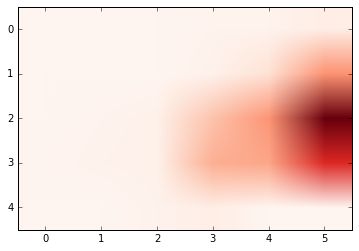

LenBin,"(0.0, 0.1]","(0.1, 0.5]","(0.5, 1.0]","(1.0, 5.0]","(5.0, 10.0]","(10.0, 100.0]"
AADTBin,,,,,,
"(0, 100]",0.0,0.0,0.0,3.0,0.0,0.0
"(100, 500]",0.0,4.0,1.0,1.0,0.0,0.0
"(500, 2000]",0.0,8.0,14.0,41.0,3.0,0.0
"(2000, 10000]",4.0,33.0,52.0,128.0,13.0,0.0
"(10000, 50000]",1.0,6.0,13.0,58.0,3.0,0.0


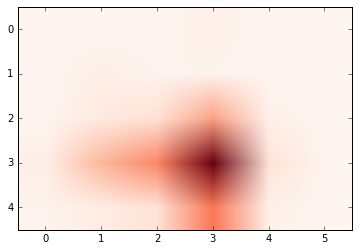

LenBin,"(0.0, 0.1]","(0.1, 0.5]","(0.5, 1.0]","(1.0, 5.0]","(5.0, 10.0]","(10.0, 100.0]"
AADTBin,,,,,,
"(100, 500]",0.0,0.0,0.0,2.0,5.0,0.0
"(500, 2000]",0.0,0.0,0.0,8.0,2.0,23.0
"(2000, 10000]",0.0,4.0,17.0,66.0,133.0,523.0
"(10000, 50000]",0.0,6.0,10.0,85.0,118.0,58.0


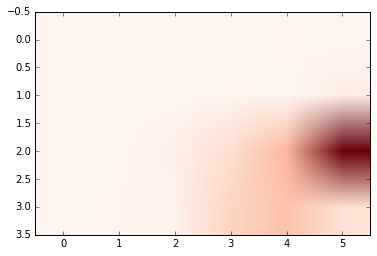

LenBin,"(0.0, 0.1]","(0.1, 0.5]","(0.5, 1.0]","(1.0, 5.0]","(5.0, 10.0]","(10.0, 100.0]"
AADTBin,,,,,,
"(100, 500]",0.0,0.0,0.0,0.0,0.0,0.0
"(500, 2000]",0.0,0.0,2.0,0.0,1.0,20.0
"(2000, 10000]",1.0,1.0,9.0,49.0,75.0,32.0
"(10000, 50000]",0.0,15.0,6.0,52.0,49.0,0.0


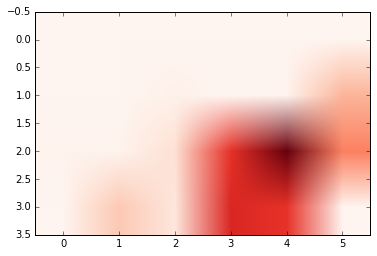

LenBin,"(0.0, 0.1]","(0.1, 0.5]","(0.5, 1.0]","(1.0, 5.0]","(5.0, 10.0]","(10.0, 100.0]"
AADTBin,,,,,,
"(0, 100]",0.0,0.0,0.0,0.0,0.0,0.0
"(100, 500]",0.0,0.0,0.0,0.0,0.0,0.0
"(500, 2000]",0.0,3.0,0.0,0.0,0.0,0.0
"(2000, 10000]",0.0,74.0,50.0,68.0,0.0,0.0
"(10000, 50000]",29.0,197.0,147.0,202.0,8.0,0.0
"(50000, 100000]",0.0,1.0,0.0,0.0,0.0,0.0


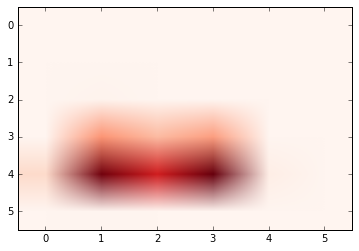

LenBin,"(0.0, 0.1]","(0.1, 0.5]","(0.5, 1.0]","(1.0, 5.0]","(5.0, 10.0]","(10.0, 100.0]"
AADTBin,,,,,,
"(100, 500]",0.0,0.0,0.0,0.0,0.0,0.0
"(500, 2000]",0.0,0.0,0.0,0.0,0.0,0.0
"(2000, 10000]",0.0,1.0,12.0,22.0,0.0,0.0
"(10000, 50000]",0.0,19.0,40.0,32.0,0.0,0.0
"(50000, 100000]",0.0,0.0,0.0,0.0,0.0,0.0


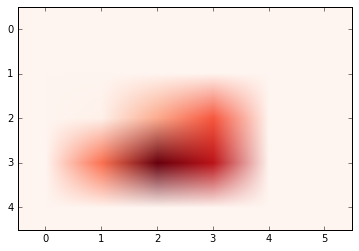

LenBin,"(0.0, 0.1]","(0.1, 0.5]","(0.5, 1.0]","(1.0, 5.0]","(5.0, 10.0]","(10.0, 100.0]"
AADTBin,,,,,,
"(2000, 10000]",0.0,1.0,1.0,1.0,0.0,0.0
"(10000, 50000]",0.0,67.0,78.0,2.0,0.0,0.0
"(50000, 100000]",0.0,7.0,0.0,24.0,0.0,0.0


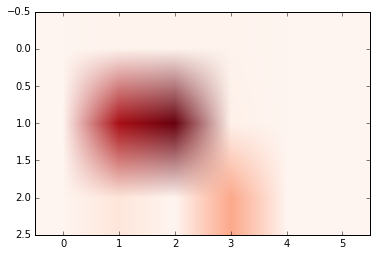

In [22]:
AADTBins = [0,100,500,2000,10000,50000,100000]
SDF['AADTBin'] = pd.cut(SDF.AADT,AADTBins)
LenBins = [0,0.1,0.5,1,5,10,100]
SDF['LenBin'] = pd.cut(SDF.Mileage,LenBins)

df = SDF.groupby(['FType','AADTBin','LenBin'])['KAB'].aggregate(sum)
df = df.unstack('LenBin')
FTypes = ['R2U','U2U','R4U','R4D','U4U','U4D','U6U']
IFTypes = ['R3ST','R4ST','RM3ST','RM4ST','U3ST','U4ST','U3SG','U4SG']
for t in FTypes:
    adf = df.loc[t]
    adf = adf.fillna(0)
    display(adf)
    plt.imshow(adf,plt.cm.Reds,aspect='auto')
    
    plt.show()